# Business Understanding

Based on the available data we ask ourselves the following question:

-Can we measure the impact of single players on the outcome of a game by comparing the success rate / win rate with them on the pitch and without them on the pitch and like that identify the players that make a team better or at least more successful?

In order to answer this question we will use the following dataset from transfermarkt:
-appearances
-club_games
-clubs
-games
-player_valuations
-players

# Measuring the impact of single players on a teams performance

To answer this question we first need to identify all the games a player is under contract with a specific team. For this we use an approximation and assume that a contract starts with a players first game and ends with a players last game for a club.

Then from those games we can identify the ones where the player has actually played. Then we calculate the win rate (# of games won / # of total games) of the two subsets and calculate the delta of these two win rates per player, club and season in order to identify the players that have had a high impact on a teams performance.

We then calculate the correlation between the market value and the delta of the win rates in order to test, if this metric can be used for scouting purposes.

# Data Loading and Data Understanding

The data we will be using are from transfermarkt.de. A website that has information of football statistics.

I quickly explain the different datasets:

df_app has information on players appearances in games and their individual statistics like goals scored, assists provided, minutes played and cards received. It has the app_id, the game_id and the player_id as a main identifier.

df_club_games has information for the games of a specific club. E.g. the amount of goals scored and received, the own position at the time of the game and the opponents, etc. It has the game_id and the club_id as a main identifier

df_clubs contains all the information for a specific club with the club_id as a main identifier.

df_games is similar to the club_games dataframe but also contains information regarding the season this game took place in, which is important for our analysis. It has the game_id as a main identifier

df_player_val contains information on the market valuations for each player and also the date when that valuation took place. It has the player_id as a main identifier

df_players contains information on a player. His position, name, etc. It has the player_id as a main identifier.

In order to connect these datasets we can use the game_id, player_id and club_id.

In [115]:
#import relevant libraries
#read in data files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_app = pd.read_csv('Data Files/appearances.csv')
df_club_games = pd.read_csv('Data Files/club_games.csv')
df_clubs = pd.read_csv('Data Files/clubs.csv')
df_games = pd.read_csv('Data Files/games.csv')
df_player_val = pd.read_csv('Data Files/player_valuations.csv')
df_players = pd.read_csv('Data Files/players.csv')

In [99]:
print(df_app.columns)
print("\n")
print(df_club_games.columns)
print("\n")
print(df_clubs.columns)
print("\n")
print(df_games.columns)
print("\n")
print(df_player_val.columns)
print("\n")
print(df_players.columns)

Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played'],
      dtype='object')


Index(['game_id', 'club_id', 'own_goals', 'own_position', 'own_manager_name',
       'opponent_id', 'opponent_goals', 'opponent_position',
       'opponent_manager_name', 'hosting', 'is_win'],
      dtype='object')


Index(['club_id', 'club_code', 'name', 'domestic_competition_id', 'squad_size',
       'average_age', 'foreigners_number', 'national_team_players',
       'stadium_name', 'stadium_seats', 'net_transfer_record', 'last_season',
       'url'],
      dtype='object')


Index(['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'url', 'aggregate',
       'competition_type'],
      dtype='object')


Index(['player_i

# Handling missing values

In this step we will inspect each dataset for missing values and then clean the data depending on the missing values.

In [29]:
df_app.isna().sum()

appearance_id               0
game_id                     0
player_id                   0
player_club_id              0
player_current_club_id      0
date                        0
player_name               335
competition_id              0
yellow_cards                0
red_cards                   0
goals                       0
assists                     0
minutes_played              0
dtype: int64

In this case we will fill the missing players names with N/A values, since we will join the data based on the id's.

In [30]:
df_app = df_app.fillna("N/A")

In [31]:
df_club_games.isna().sum()

game_id                     0
club_id                     0
own_goals                   0
own_position                0
own_manager_name         1360
opponent_id                 0
opponent_goals              0
opponent_position           0
opponent_manager_name    1360
hosting                     0
is_win                      0
dtype: int64

In this case we will fill the missing coaches names with N/A values, since we will not use the coaches names.

In [32]:
df_club_games = df_club_games.fillna("N/A")

In [33]:
df_clubs.isna().sum()

club_id                      0
club_code                    0
name                         0
domestic_competition_id      0
total_market_value         426
squad_size                   0
average_age                 38
foreigners_number            0
foreigners_percentage       47
national_team_players        0
stadium_name                 0
stadium_seats                0
net_transfer_record          0
coach_name                 426
last_season                  0
url                          0
dtype: int64

Since we will not use the columns with the missing values, we will drop them.

In [34]:
df_clubs = df_clubs.drop(columns=["total_market_value", "foreigners_percentage", "coach_name"], axis=1)

In [35]:
df_games.isna().sum()

game_id                       0
competition_id                0
season                        0
round                         0
date                          0
home_club_id                  0
away_club_id                  0
home_club_goals               0
away_club_goals               0
home_club_position            0
away_club_position            0
home_club_manager_name      680
away_club_manager_name      680
stadium                     188
attendance                 9035
referee                     575
url                           0
home_club_name            10378
away_club_name             9302
aggregate                     0
competition_type              0
dtype: int64

Since we will not use the columns with the missing values, we will drop them.

In [36]:
df_games = df_games.drop(columns=["home_club_manager_name", "away_club_manager_name", "stadium",
                                 "attendance", "referee", "home_club_name", "away_club_name"], axis=1)

In [37]:
df_player_val.isna().sum()

player_id                              0
last_season                            0
datetime                               0
date                                   0
dateweek                               0
market_value_in_eur                    0
n                                      0
current_club_id                        0
player_club_domestic_competition_id    0
dtype: int64

There are no missing values, hence there is no action required.

In [38]:
df_players.isna().sum()

player_id                                   0
first_name                               1890
last_name                                   0
name                                        0
last_season                                 0
current_club_id                             0
player_code                                 0
country_of_birth                         3293
city_of_birth                            2115
country_of_citizenship                   1267
date_of_birth                              45
sub_position                              172
position                                    0
foot                                     2310
height_in_cm                             2027
market_value_in_eur                     10904
highest_market_value_in_eur              1340
contract_expiration_date                11495
agent_name                              14973
image_url                                   0
url                                         0
current_club_domestic_competition_

Since we will not use the columns with the missing values, we will drop them.

In [39]:
df_players = df_players.drop(columns=["first_name", "country_of_birth", "city_of_birth", "country_of_citizenship",
                                 "date_of_birth", "sub_position", "foot", "height_in_cm", "market_value_in_eur",
                                 "highest_market_value_in_eur", "contract_expiration_date", "agent_name"], axis=1)

# Data Preparation

Objective: Derive a dataframe grouped by player_id, club_id, and season and the respective win rates on and off pitch

In [40]:
# Merge df_players and df_app based on player_id
merged_df = pd.merge(df_players, df_app, on='player_id', how='outer')

# Merge df_players_app and df_games based on game_id
merged_df = pd.merge(merged_df, df_games, on='game_id', how='outer')

# Remove duplicates
merged_df = merged_df.drop_duplicates()

Create a dataframe per player and club that shows the contract start date (date of first game with the club) and contract end date (date of last game with the club) for a specific club.

In [41]:
#create a dataframe per player that shows the contract start and end date with a club
#to simplify and due to missing contract data we will assume the contract of a player with a club starts with
#his first game and ends with his last game for a specific club

#create subset with player, club, game info and the date for the game from the merged dataset
contract_df = merged_df[['player_id', 'date_x', 'game_id', 'player_club_id']]
contract_df = contract_df.dropna()

#transform date column into date type
contract_df['date_x'] = pd.to_datetime(contract_df['date_x'])

#find the contract start 
contract_df_min = contract_df.groupby(['player_id', 'player_club_id'])['date_x'].min()
#find the contract start end
contract_df_max = contract_df.groupby(['player_id', 'player_club_id'])['date_x'].max()

# Convert the Series back to a DataFrame
contract_df_min = contract_df_min.reset_index()
contract_df_min = contract_df_min.rename(columns={'date_x': 'contract_start'})
contract_df_max = contract_df_max.reset_index()
contract_df_max = contract_df_max.rename(columns={'date_x': 'contract_end'})

# Merge contract_max to contract start
contract_df = pd.merge(contract_df_min, contract_df_max, on=['player_id', 'player_club_id'], how='outer')

#change contract df columns player id and player club id to integers
contract_df["player_id"] = contract_df["player_id"].astype(int)
contract_df["player_club_id"] = contract_df["player_club_id"].astype(int)

Merge the contract information with the club games data in order to derive a dataframe that shows which players were under contract with a certain club for a certain game.

In [42]:
#merge contract information on club game data
df_player_games = pd.merge(contract_df, df_club_games, left_on = 'player_club_id', right_on= 'club_id')
df_player_games = pd.merge(df_player_games, df_games[['game_id', 'date']], on= 'game_id')

#set date column to datetime
df_player_games['date'] = pd.to_datetime(df_player_games['date'])

In [43]:
#check if player was an active team member during the game
df_player_games['was_team_member'] = df_player_games.apply(lambda row: 1 if row['contract_start'] 
                                                                 <= row['date'] <= row['contract_end'] 
                                                                 else 0, axis=1)

#filter for all the games where the player was an active member of team
df_player_games = df_player_games[df_player_games["was_team_member"] == 1]

Calculate the results for the club games

In [44]:
#function for deriving the result of the game
def calculate_results (own_goals, opp_goals):
    if own_goals > opp_goals:
        result = 'w'
    elif own_goals == opp_goals:
        result = 'd'
    else:
        result = 'l'
    return result

#apply function
df_player_games["result"] = df_player_games.apply(lambda row: calculate_results (row['own_goals'], 
                                                                                row['opponent_goals']),
                                                               axis=1)

In [45]:
#create new dataframe for only the games that a player has actually played
df_player_games_played = pd.merge(df_app, df_club_games, left_on=['game_id', 'player_club_id'],
                                  right_on=['game_id', 'club_id'])

#apply result function
df_player_games_played["result"] = df_player_games_played.apply(lambda row: calculate_results (row['own_goals'], 
                                                                                row['opponent_goals']),
                                                               axis=1)

In [46]:
#add season information to the dataframes
df_player_games = pd.merge(df_player_games, df_games[['game_id', 'season']], on='game_id')
df_player_games_played = pd.merge(df_player_games_played, df_games[['game_id', 'season']], on='game_id')

Create the final dataframe on a player, club and season level and count the amount of wins, draws and losses and then merge the two dataframes together.

In [47]:
# Create a pivot table to count the results per player in the matches he has played
player_results_per_season = df_player_games_played.pivot_table(index=['player_id', 'season', 'club_id'], columns='result', aggfunc='size', fill_value=0)

# Rename columns
player_results_per_season.columns = ['draws_in_matches_played', 'losses_in_matches_played', 'wins_in_matches_played']

# Reset index to make 'player_id' a regular column
player_results_per_season.reset_index(inplace=True)

# Create a pivot table to count the results per player in the matches he has played
team_results_per_season = df_player_games.pivot_table(index=['player_id', 'season', 'club_id'], columns='result', aggfunc='size', fill_value=0)

# Rename columns
team_results_per_season.columns = ['draws_in_matches_overall', 'losses_in_matches_overall', 'wins_in_matches_overall']

# Reset index to make 'player_id' a regular column
team_results_per_season.reset_index(inplace=True)

In [48]:
merged_results = pd.merge(team_results_per_season, player_results_per_season, on = ["player_id", "season", "club_id"])

Calculate the required metrics namely win rate on and off pitch.

In [49]:
#get results for matches that player didnt play but was in the team
merged_results['wins_in_matches_not_played'] = merged_results['wins_in_matches_overall']-merged_results['wins_in_matches_played']
    
merged_results['draws_in_matches_not_played'] = merged_results['draws_in_matches_overall']-merged_results['draws_in_matches_played']
    
merged_results['losses_in_matches_not_played'] = merged_results['losses_in_matches_overall']-merged_results['losses_in_matches_played']

columns_to_drop = ['draws_in_matches_overall', 'losses_in_matches_overall', 'wins_in_matches_overall']
merged_results = merged_results.drop(columns= columns_to_drop, axis=1)

merged_results["games_on_pitch"] = merged_results["draws_in_matches_played"]+merged_results["losses_in_matches_played"]+merged_results["wins_in_matches_played"]
merged_results["games_off_pitch"] = merged_results["draws_in_matches_not_played"]+merged_results["losses_in_matches_not_played"]+merged_results["wins_in_matches_not_played"]

#calculate the win rate when a player was playing vs the win rate when the player was not playing
merged_results["win_rate_on_pitch"] = merged_results["wins_in_matches_played"]/merged_results["games_on_pitch"]
merged_results["win_rate_off_pitch"] = merged_results["wins_in_matches_not_played"]/merged_results["games_off_pitch"]

#calculate the delta of the two win rates
merged_results["win_rate_delta_on_off_pitch"] = merged_results["win_rate_on_pitch"] - merged_results["win_rate_off_pitch"]

#calculate overall win rate of the team
merged_results['win_rate_overall'] = (merged_results['wins_in_matches_not_played']+merged_results['wins_in_matches_played'])/(merged_results['games_on_pitch']+merged_results['games_off_pitch'])


Enrich the dataframe with further information like player names, position and club names

In [50]:
#enrich dataset with additional information
merged_results = pd.merge(merged_results, df_players[['player_id', 'name', 'position']], on='player_id')
merged_results = pd.merge(merged_results, df_clubs[['club_id', 'name']], on='club_id')

#rename the columns
merged_results = merged_results.rename(columns={'name_x': 'name'})
merged_results = merged_results.rename(columns={'name_y': 'club name'})


Calculate the last player valuation of a season in order to use it for a correlation analysis. 
In order to derive the last player valuation of a season we take the last date before August when a valuation was posted for a player

In [51]:
#preparation of player valuation on a saison basis - valuation date is the last valuation before August each year
df_player_val["date"] = pd.to_datetime(df_player_val["date"])
df_player_val["year"] = df_player_val["date"].dt.year
df_player_val["month"] = df_player_val["date"].dt.month
df_player_val = df_player_val[df_player_val["month"]<8]
df_player_val["season"] =df_player_val["year"] - 1

df_val_agg = df_player_val.groupby(['player_id', 'season']).agg({'date': 'max'}).reset_index()
df_val_agg = pd.merge(df_val_agg, df_player_val[["date", "player_id", "market_value_in_eur"]], on=["player_id", "date"], how="inner")

#merge valuation data with merged results
merged_results = pd.merge(merged_results, df_val_agg[["player_id", "season", "market_value_in_eur"]], 
                      on=["player_id", "season"])

# Data Analysis

Objective: Analyse the derived metric. See if there is a correlation with market valuation and also see if the metric in combination with football knowledge can be used to scout promising players.

In order to derive a valuable insights, we only look at players that have played in at least 20 games and did not play in at least 10 games.

In [52]:
#we filter just for players that have played in at least 15 games in a season
merged_results_15_games = merged_results[(merged_results["games_on_pitch"]>=20) & 
                                        (merged_results["games_off_pitch"]>=10)]
merged_results_15_games[['player_id', 'season', 'games_on_pitch', 'games_off_pitch','win_rate_on_pitch',
                        'win_rate_off_pitch','win_rate_delta_on_off_pitch', 
                        'name', 'position', 
                        'club name']].sort_values(by=['win_rate_delta_on_off_pitch'], ascending=False).head(10)

,player_id,season,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,name,position,club name
40147,395862,2019,31,13,0.645161,0.000000,0.645161,Hüseyin Türkmen,Defender,Trabzonspor
19715,59344,2014,41,18,0.902439,0.333333,0.569106,Asier Illarramendi,Midfield,Real Madrid
8702,51168,2015,21,18,0.714286,0.166667,0.547619,Jens Hegeler,Midfield,Hertha BSC
43548,36881,2015,28,13,0.607143,0.076923,0.530220,Nemanja Pejcinovic,Defender,Lokomotiv Moscow
438,191422,2017,34,14,0.529412,0.000000,0.529412,Mahmoud Dahoud,Midfield,Borussia Dortmund
53948,85430,2014,21,16,0.714286,0.187500,0.526786,Jaba Lipartia,Midfield,Zorya Lugansk
23717,217879,2020,24,10,0.625000,0.100000,0.525000,Patrik Hrosovsky,Midfield,KRC Genk
57486,343959,2021,22,14,0.590909,0.071429,0.519481,Erhan Masovic,Defender,VfL Bochum
1711,300716,2022,33,13,0.818182,0.307692,0.510490,Kieran Tierney,Defender,Arsenal FC
41772,504090,2021,24,10,0.708333,0.200000,0.508333,Paulo Bernardo,Midfield,SL Benfica


If we are looking at the top10 with highest win-rate delta, we don't see any players that are particularly famous for being players that make a difference.

In [53]:
#calculate correlation between delta of on pitch and off pitch win rate vs. market value to see if this kpi can be 
#used for predicting market valuation

merged_results_subset = merged_results_15_games[["win_rate_delta_on_off_pitch", "market_value_in_eur"]]

print(merged_results_subset.corr())

                             win_rate_delta_on_off_pitch  market_value_in_eur
win_rate_delta_on_off_pitch                     1.000000            -0.001975
market_value_in_eur                            -0.001975             1.000000


The correlation value for the win_rate delta and the market value shows that our derived metric has almost no correlation with market value. 

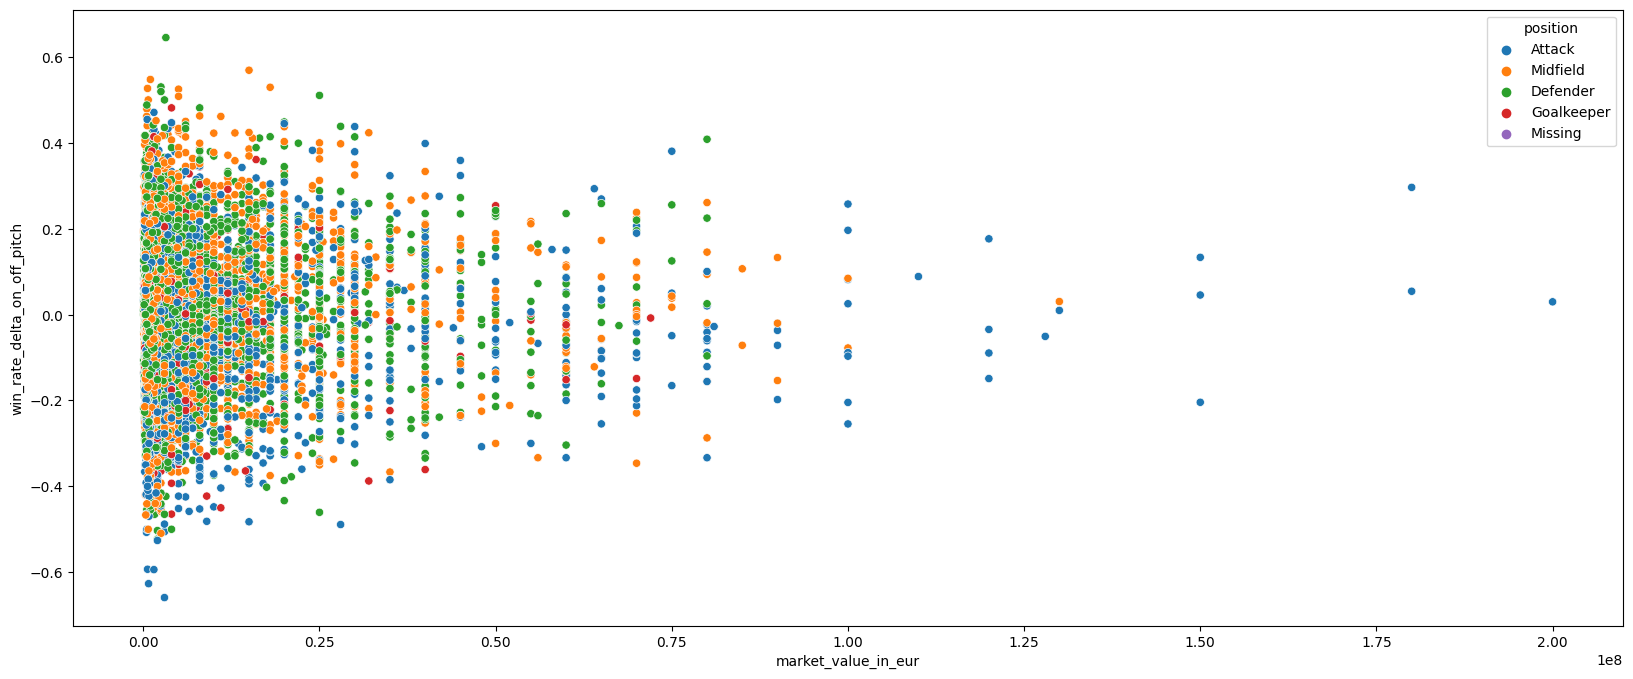

In [56]:
plt.figure(figsize=(20, 8))

sns.scatterplot(x='market_value_in_eur', y='win_rate_delta_on_off_pitch',
                data=merged_results_15_games,
                hue='position' )

plt.show()

This can be also seen in the graph that there is no apparent correlation between the two metrics.

In [66]:
len(merged_results_15_games[(merged_results_15_games["market_value_in_eur"]>50000000) &
                       (merged_results_15_games["win_rate_delta_on_off_pitch"]>0)])

79

In [67]:
len(merged_results_15_games[(merged_results_15_games["market_value_in_eur"]>50000000) &
                       (merged_results_15_games["win_rate_delta_on_off_pitch"]<0)])

104

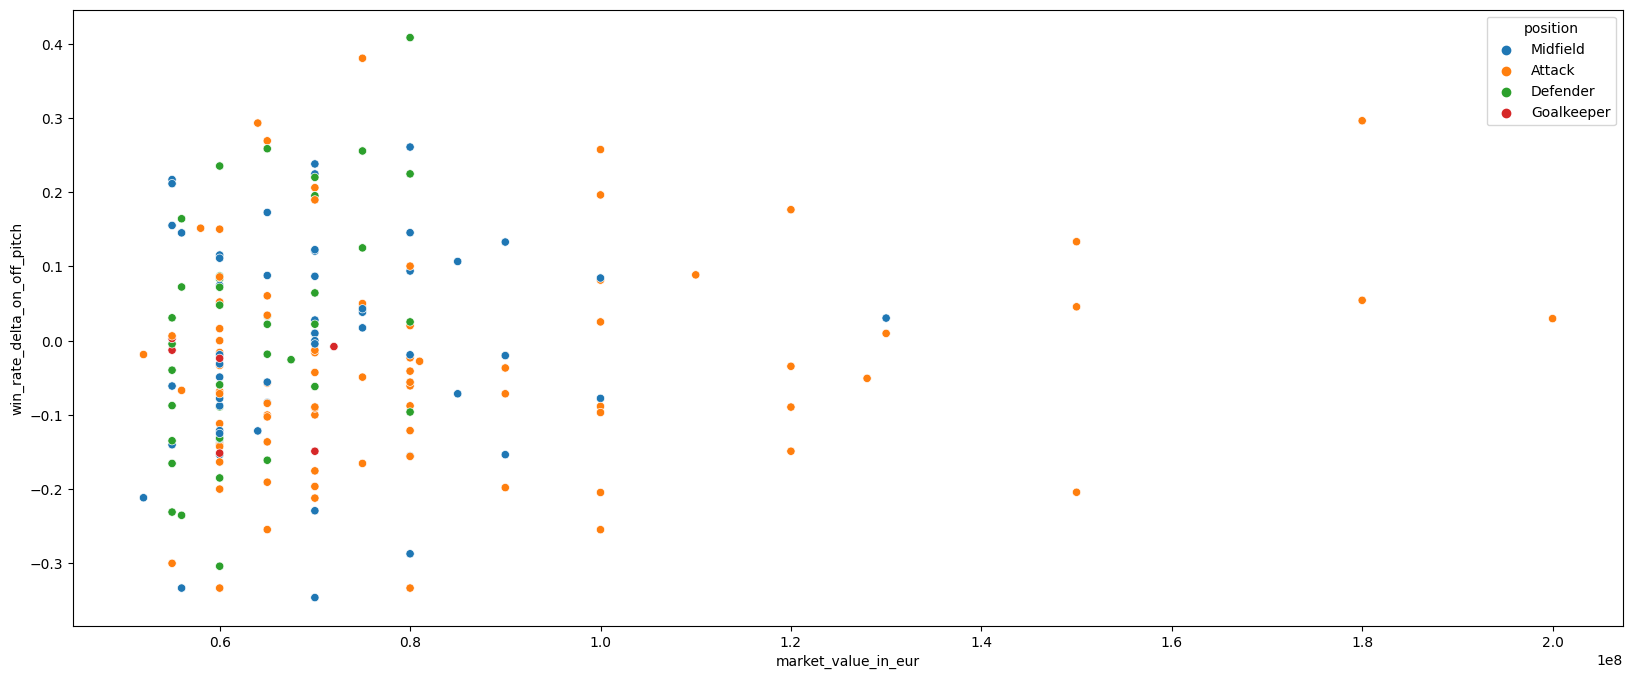

In [68]:
plt.figure(figsize=(20, 8))

sns.scatterplot(x='market_value_in_eur', y='win_rate_delta_on_off_pitch',
                data=merged_results_15_games[merged_results_15_games["market_value_in_eur"]>50000000],
                hue='position' )

plt.show()

If we are only looking at the players that were valued in a season more than 50.000.000 € we can even see that for more players (104) the teams actually had a lower win rate when they were on the field. 

The explanation for that could be, that these good/expensive players were actually not playing in the rather unimportant games, which are games that have a higher probability to be lost since teams do not take them so seriously.

In [294]:
merged_results_15_games[(merged_results_15_games["season"]==2020)&
                                            (merged_results_15_games["market_value_in_eur"]>50000000)][['player_id','season', 'games_on_pitch', 'games_off_pitch','win_rate_on_pitch',
                        'win_rate_off_pitch','win_rate_delta_on_off_pitch', 
                        'name', 'position', 
                        'club name', "market_value_in_eur"]].sort_values(by=['win_rate_delta_on_off_pitch'], ascending=True).head(30)

,player_id,season,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,name,position,club name,market_value_in_eur
7779,309400,2020,44,13,0.500000,0.846154,-0.346154,Kai Havertz,Midfield,Chelsea FC,70000000
18753,134425,2020,45,11,0.711111,0.909091,-0.197980,Raheem Sterling,Attack,Manchester City,90000000
15660,122153,2020,39,18,0.512821,0.666667,-0.153846,Paul Pogba,Midfield,Manchester United,60000000
3662,433177,2020,44,11,0.500000,0.636364,-0.136364,Bukayo Saka,Attack,Arsenal FC,65000000
2990,243714,2020,39,11,0.717949,0.818182,-0.100233,Kingsley Coman,Attack,Bayern Munich,65000000
26175,68290,2020,28,23,0.607143,0.695652,-0.088509,Neymar,Attack,Paris Saint-Germain,100000000
1609,225693,2020,41,10,0.512195,0.600000,-0.087805,Fabinho,Midfield,Liverpool FC,60000000
16903,182712,2020,40,16,0.725000,0.812500,-0.087500,João Cancelo,Defender,Manchester City,55000000
11770,88755,2020,36,20,0.722222,0.800000,-0.077778,Kevin De Bruyne,Midfield,Manchester City,100000000
3617,363205,2020,41,15,0.731707,0.800000,-0.068293,Gabriel Jesus,Attack,Manchester City,60000000


And if we are looking closer at the players that were valued more than 50 Mio. € in the 2020/2021 season and sort by the win rate delta in ascending order, we see Kai Havertz in with the lowest win rate delta (or the highest negative win rate delta). However in that season he actually scored the winning goal in the champions league final and he was seen as one of the "winners" in the Chelsea team. However the data suggests differently. This showcases how one goal, or one game event can actually skew the perception of a whole season.

In [300]:
#calculate total win-rate delta independent of the season

merged_results_total = merged_results.groupby(['player_id', 'name']).agg(
    wins_in_matches_played=pd.NamedAgg(column='wins_in_matches_played', aggfunc='sum'),
    wins_in_matches_not_played=pd.NamedAgg(column='wins_in_matches_not_played', aggfunc='sum'),
    games_on_pitch=pd.NamedAgg(column='games_on_pitch', aggfunc='sum'),
    games_off_pitch=pd.NamedAgg(column='games_off_pitch', aggfunc='sum'),
).reset_index()

merged_results_total["win_rate_on_pitch"] = merged_results_total["wins_in_matches_played"] / merged_results_total["games_on_pitch"]
merged_results_total["win_rate_off_pitch"] = merged_results_total["wins_in_matches_not_played"] / merged_results_total["games_off_pitch"]
merged_results_total["delta"] = merged_results_total["win_rate_on_pitch"] - merged_results_total["win_rate_off_pitch"]


merged_results_total[(merged_results_total["games_on_pitch"]>50) &
                    (merged_results_total["games_off_pitch"]>30)].sort_values(by=['delta'], ascending=False).head(30)

,player_id,name,wins_in_matches_played,wins_in_matches_not_played,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,delta
4359,79045,Jeroen Zoet,164,36,255,122,0.643137,0.295082,0.348055
4038,72736,Guillaume François,48,25,67,60,0.716418,0.416667,0.299751
14642,467250,Yukhym Konoplya,50,12,78,35,0.641026,0.342857,0.298168
7769,181469,Tomas Hajek,34,24,56,77,0.607143,0.311688,0.295455
1286,27941,Danijel Subasic,105,10,196,41,0.535714,0.243902,0.291812
10723,282250,Birger Meling,48,7,93,31,0.516129,0.225806,0.290323
15851,569598,Youssouf Fofana,64,11,117,41,0.547009,0.268293,0.278716
13326,388581,Thibang Phete,24,1,79,31,0.303797,0.032258,0.271539
4504,82713,Abdullah Durak,51,8,126,59,0.404762,0.135593,0.269169
1487,31910,Felix Kroos,26,8,54,37,0.481481,0.216216,0.265265


And if we are looking at the win rate delta irrespective of the season, we also dont see any significant players.

# Single Player Analysis

Objective: Analyse the data for a single player over several season

In order to facilitate the analysis we write a function that delivers two graphs that show the win-rate delta and the overall win-rate for a single player over several seasons. In the first graph we also show on a 2nd axis the amount of games off pitch and in the second graph the market value in euros.

In [104]:
#function for plotting a single players metrics over several seasons
def single_player_analysis(df):
    # Create a line plot with percentage on the left y-axis
    fig, ax1 = plt.subplots(figsize=(20, 10))
    sns.lineplot(x='season', y='win_rate_overall', data=df, label='win_rate_overall', ax=ax1, alpha=1, color='green')
    sns.lineplot(x='season', y='win_rate_delta_on_off_pitch', data=df, label='delta', ax=ax1, alpha=1, color='blue')
    # Set y-axis label for the left y-axis
    ax1.set_ylabel('win_rate_overall')
    # Create a bar plot with absolute numbers on the right y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x='season', y='games_off_pitch', ax=ax2, data=df, label='number_games_off_pitch', color='orange', alpha=1)
    # Set y-axis label for the right y-axis
    ax2.set_ylabel('Number off pitch games')
    # Show the legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # Show the plot
    plt.show()
    # Create a line plot with percentage on the left y-axis
    fig, ax1 = plt.subplots(figsize=(20, 10))
    sns.lineplot(x='season', y='win_rate_overall', data=df, label='win_rate_overall', ax=ax1, alpha=1, color='green')
    sns.lineplot(x='season', y='win_rate_delta_on_off_pitch', data=df, label='delta', ax=ax1, alpha=1, color='blue')
    # Set y-axis label for the left y-axis
    ax1.set_ylabel('win_rate_overall')
    # Create a bar plot with absolute numbers on the right y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x='season', y='market_value_in_eur', ax=ax2, data=df, label='market_value', color='orange', alpha=1)
    # Set y-axis label for the right y-axis
    ax2.set_ylabel('Market Value')
    # Show the legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # Show the plot
    plt.show()

We first analyse the seasonal performance of the win rate delta metric for the player Hüseyin Türkmen, who had the highest win rate delta of all the players.

In [105]:
df_single_player = merged_results[merged_results["player_id"]==395862]

In [106]:
df_single_player.head()

,player_id,season,club_id,draws_in_matches_played,losses_in_matches_played,wins_in_matches_played,wins_in_matches_not_played,draws_in_matches_not_played,losses_in_matches_not_played,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,win_rate_overall,name,position,club name,market_value_in_eur
40145,395862,2017,449,0,0,2,0,0,0,2,0,1.000000,NaN,NaN,1.000000,Hüseyin Türkmen,Defender,Trabzonspor,50000
40146,395862,2018,449,5,4,14,4,4,3,23,11,0.608696,0.363636,0.245059,0.529412,Hüseyin Türkmen,Defender,Trabzonspor,2000000
40147,395862,2019,449,9,2,20,0,4,9,31,13,0.645161,0.000000,0.645161,0.454545,Hüseyin Türkmen,Defender,Trabzonspor,3200000
40148,395862,2020,449,6,1,4,15,8,6,11,29,0.363636,0.517241,-0.153605,0.475000,Hüseyin Türkmen,Defender,Trabzonspor,1400000
40149,395862,2021,449,7,1,5,19,6,4,13,29,0.384615,0.655172,-0.270557,0.571429,Hüseyin Türkmen,Defender,Trabzonspor,600000


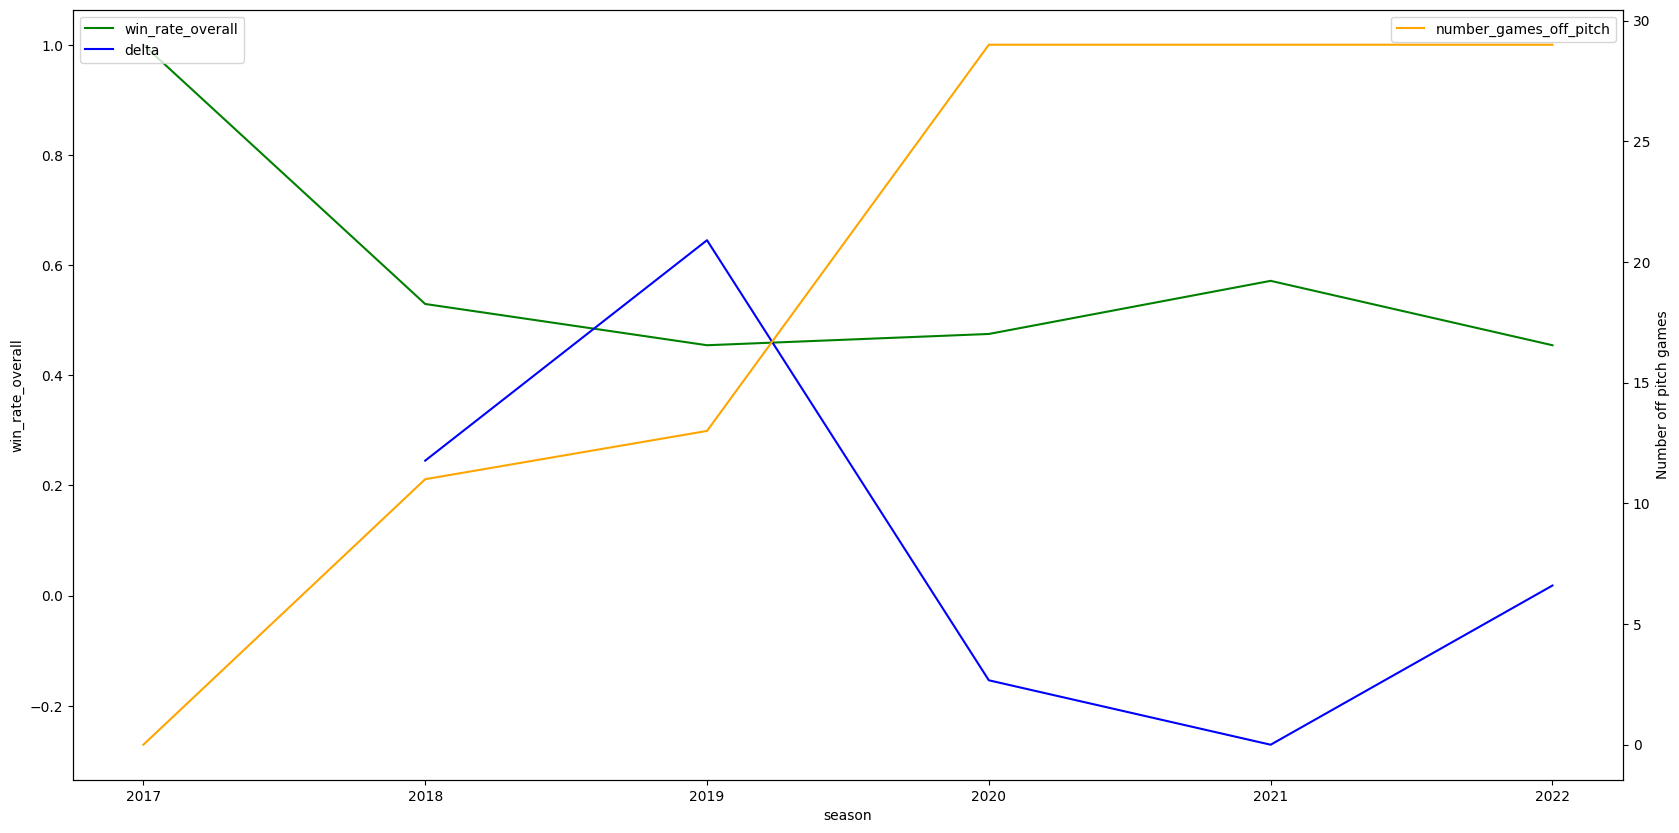

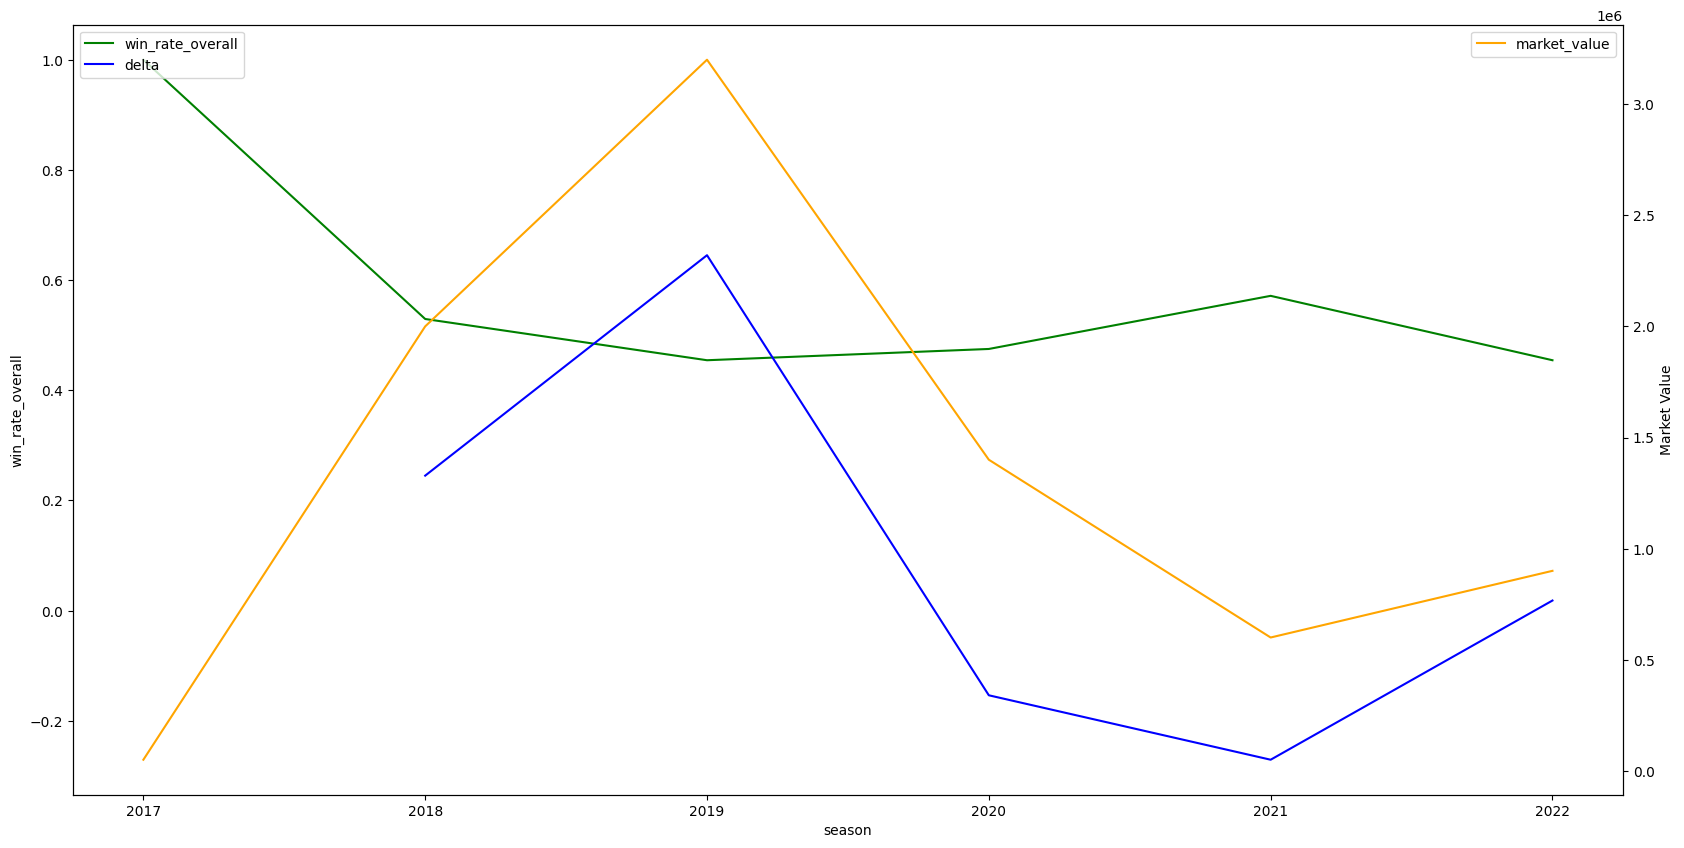

In [107]:
single_player_analysis(df_single_player)

In [70]:
df_single_player.head()

,player_id,season,club_id,draws_in_matches_played,losses_in_matches_played,wins_in_matches_played,wins_in_matches_not_played,draws_in_matches_not_played,losses_in_matches_not_played,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,win_rate_overall,name,position,club name,market_value_in_eur
40145,395862,2017,449,0,0,2,0,0,0,2,0,1.000000,NaN,NaN,1.000000,Hüseyin Türkmen,Defender,Trabzonspor,50000
40146,395862,2018,449,5,4,14,4,4,3,23,11,0.608696,0.363636,0.245059,0.529412,Hüseyin Türkmen,Defender,Trabzonspor,2000000
40147,395862,2019,449,9,2,20,0,4,9,31,13,0.645161,0.000000,0.645161,0.454545,Hüseyin Türkmen,Defender,Trabzonspor,3200000
40148,395862,2020,449,6,1,4,15,8,6,11,29,0.363636,0.517241,-0.153605,0.475000,Hüseyin Türkmen,Defender,Trabzonspor,1400000
40149,395862,2021,449,7,1,5,19,6,4,13,29,0.384615,0.655172,-0.270557,0.571429,Hüseyin Türkmen,Defender,Trabzonspor,600000


It seems that for this player the season of 2019 was actually an outlier. In the years after that his team actually performed worse with him on the pitch.

Now we analyse the seasonal performance of the win rate delta metric for the player Asier Illarramendi, who had the 2nd highest win rate delta of all the players.

In [81]:
df_single_player = merged_results[merged_results["player_id"]==59344]

In [82]:
df_single_player.head()

,player_id,season,club_id,draws_in_matches_played,losses_in_matches_played,wins_in_matches_played,wins_in_matches_not_played,draws_in_matches_not_played,losses_in_matches_not_played,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,win_rate_overall,name,position,club name,market_value_in_eur
19715,59344,2014,418,2,2,37,6,4,8,41,18,0.902439,0.333333,0.569106,0.728814,Asier Illarramendi,Midfield,Real Madrid,15000000
40553,59344,2015,681,8,15,12,1,1,2,35,4,0.342857,0.250000,0.092857,0.333333,Asier Illarramendi,Midfield,Real Sociedad,15000000
40554,59344,2016,681,7,12,20,1,2,2,39,5,0.512821,0.200000,0.312821,0.477273,Asier Illarramendi,Midfield,Real Sociedad,15000000
40555,59344,2017,681,8,19,17,2,0,2,44,4,0.386364,0.500000,-0.113636,0.395833,Asier Illarramendi,Midfield,Real Sociedad,20000000
40556,59344,2018,681,6,7,6,5,4,5,19,14,0.315789,0.357143,-0.041353,0.333333,Asier Illarramendi,Midfield,Real Sociedad,25000000


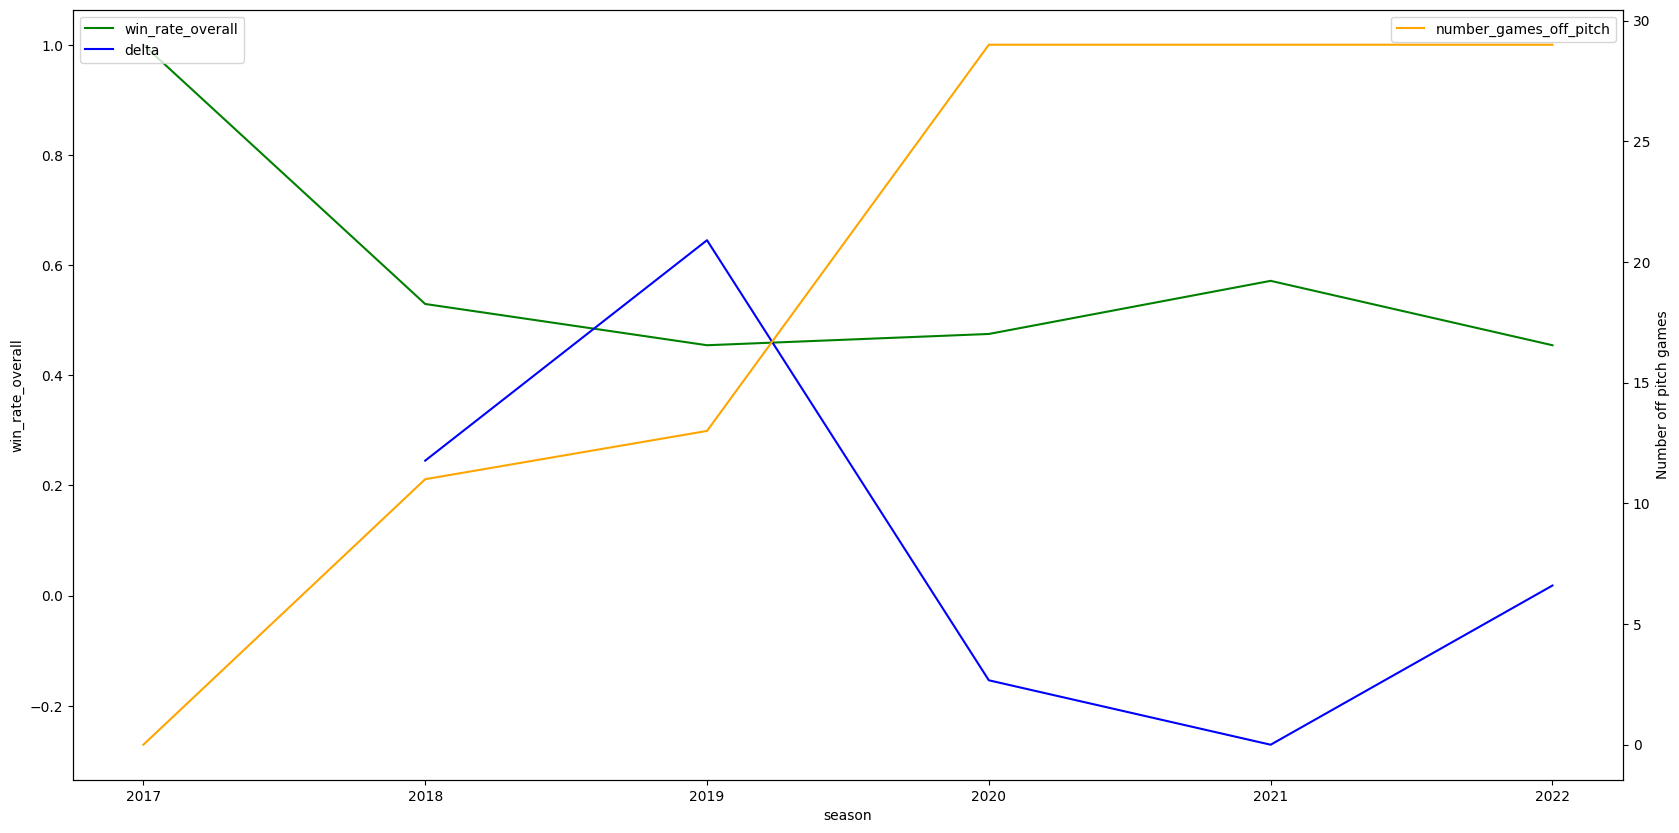

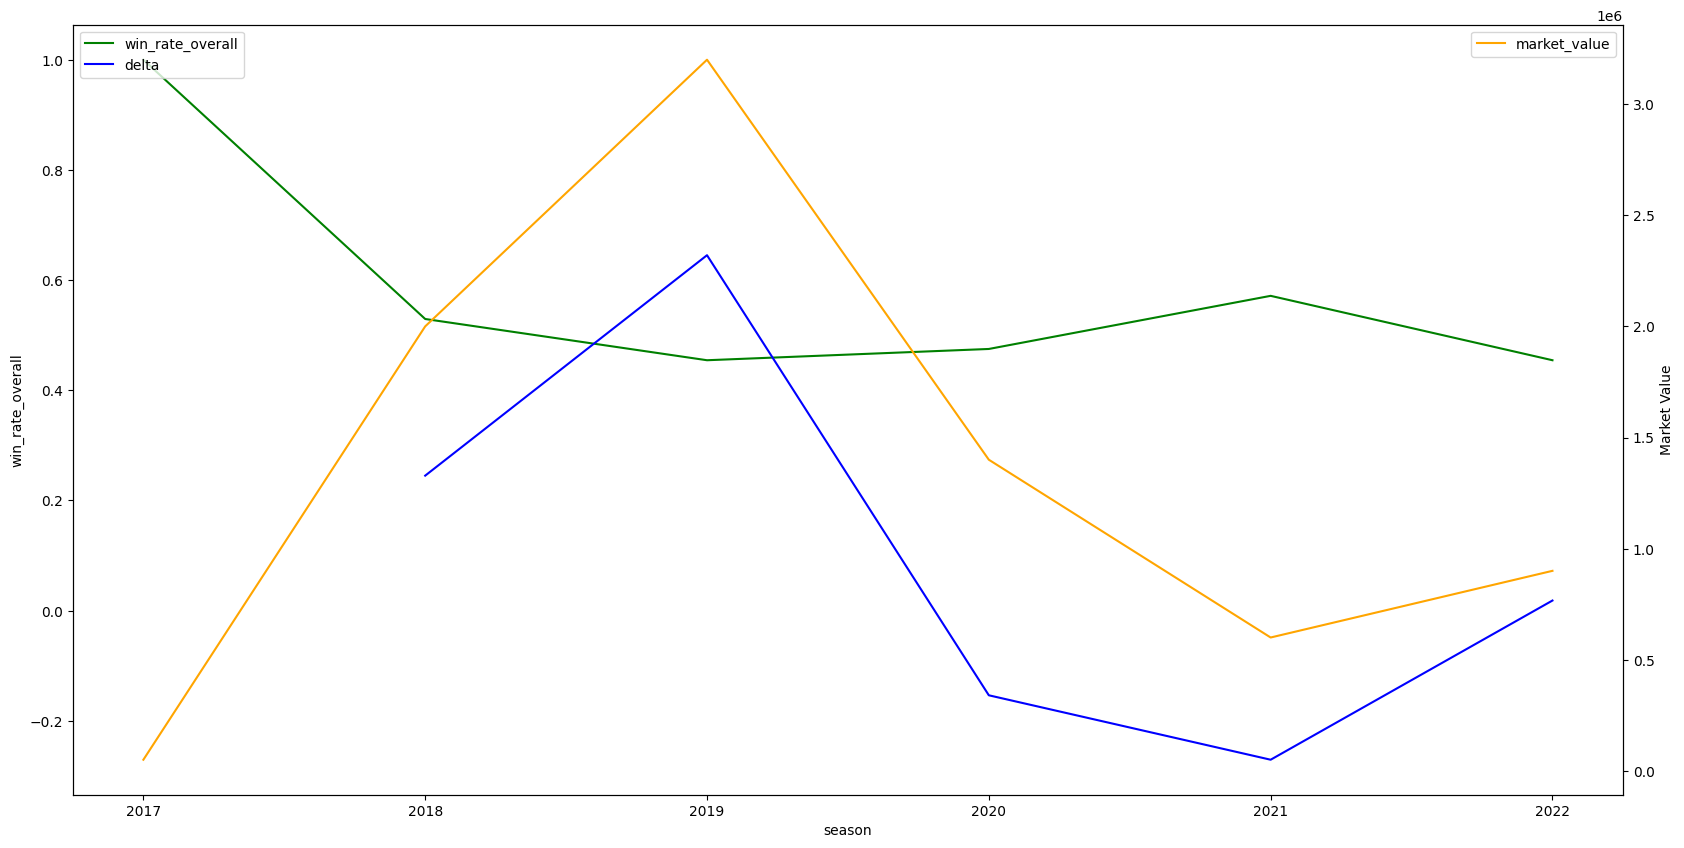

In [107]:
single_player_analysis(df_single_player)

We see that the teams he has played with have actually performed better with him on the pitch in the majority of seasons namely 2014-2016 and 2020-2022. But from 2017 until 2019 his team actually performed worse with him on the pitch.

Now take a closer look arguably the best football players of the last couple of years and the most promising for the years to come. We start with Lionel Messi.

In [109]:
df_single_player = merged_results[merged_results["player_id"]==28003]

In [110]:
df_single_player.head()

,player_id,season,club_id,draws_in_matches_played,losses_in_matches_played,wins_in_matches_played,wins_in_matches_not_played,draws_in_matches_not_played,losses_in_matches_not_played,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,win_rate_overall,name,position,club name,market_value_in_eur
16352,28003,2021,583,8,5,20,7,2,1,33,10,0.606061,0.700000,-0.093939,0.627907,Lionel Messi,Attack,Paris Saint-Germain,50000000
16353,28003,2022,583,4,7,28,3,2,2,39,7,0.717949,0.428571,0.289377,0.673913,Lionel Messi,Attack,Paris Saint-Germain,35000000
30688,28003,2014,131,4,6,47,3,0,0,57,3,0.824561,1.000000,-0.175439,0.833333,Lionel Messi,Attack,FC Barcelona,120000000
30689,28003,2015,131,7,6,36,10,2,1,49,13,0.734694,0.769231,-0.034537,0.741935,Lionel Messi,Attack,FC Barcelona,120000000
30690,28003,2016,131,7,7,38,4,2,1,52,7,0.730769,0.571429,0.159341,0.711864,Lionel Messi,Attack,FC Barcelona,120000000


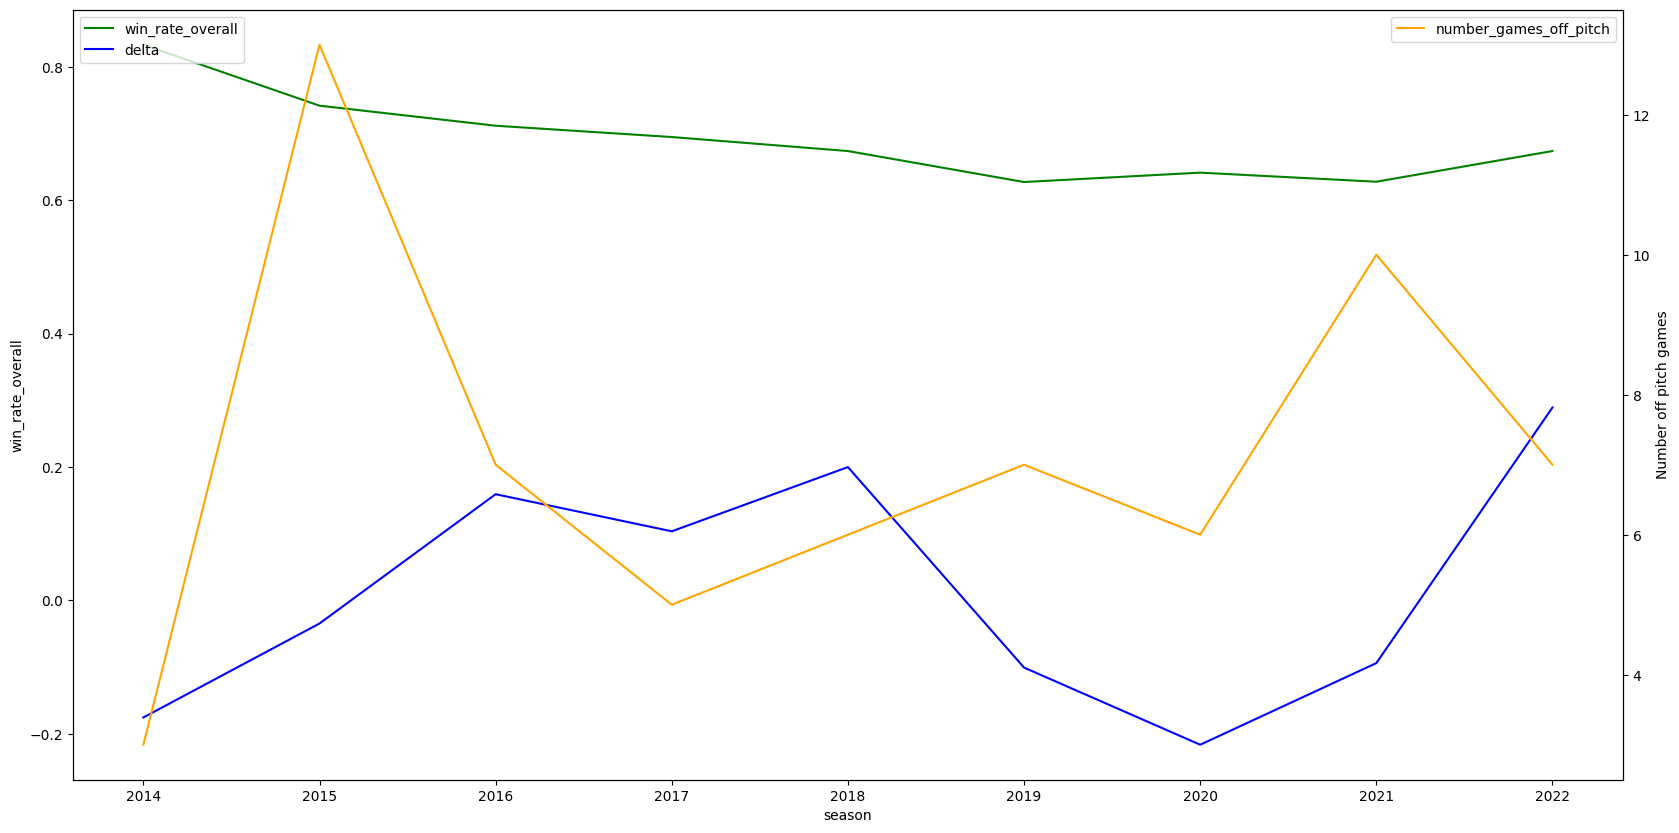

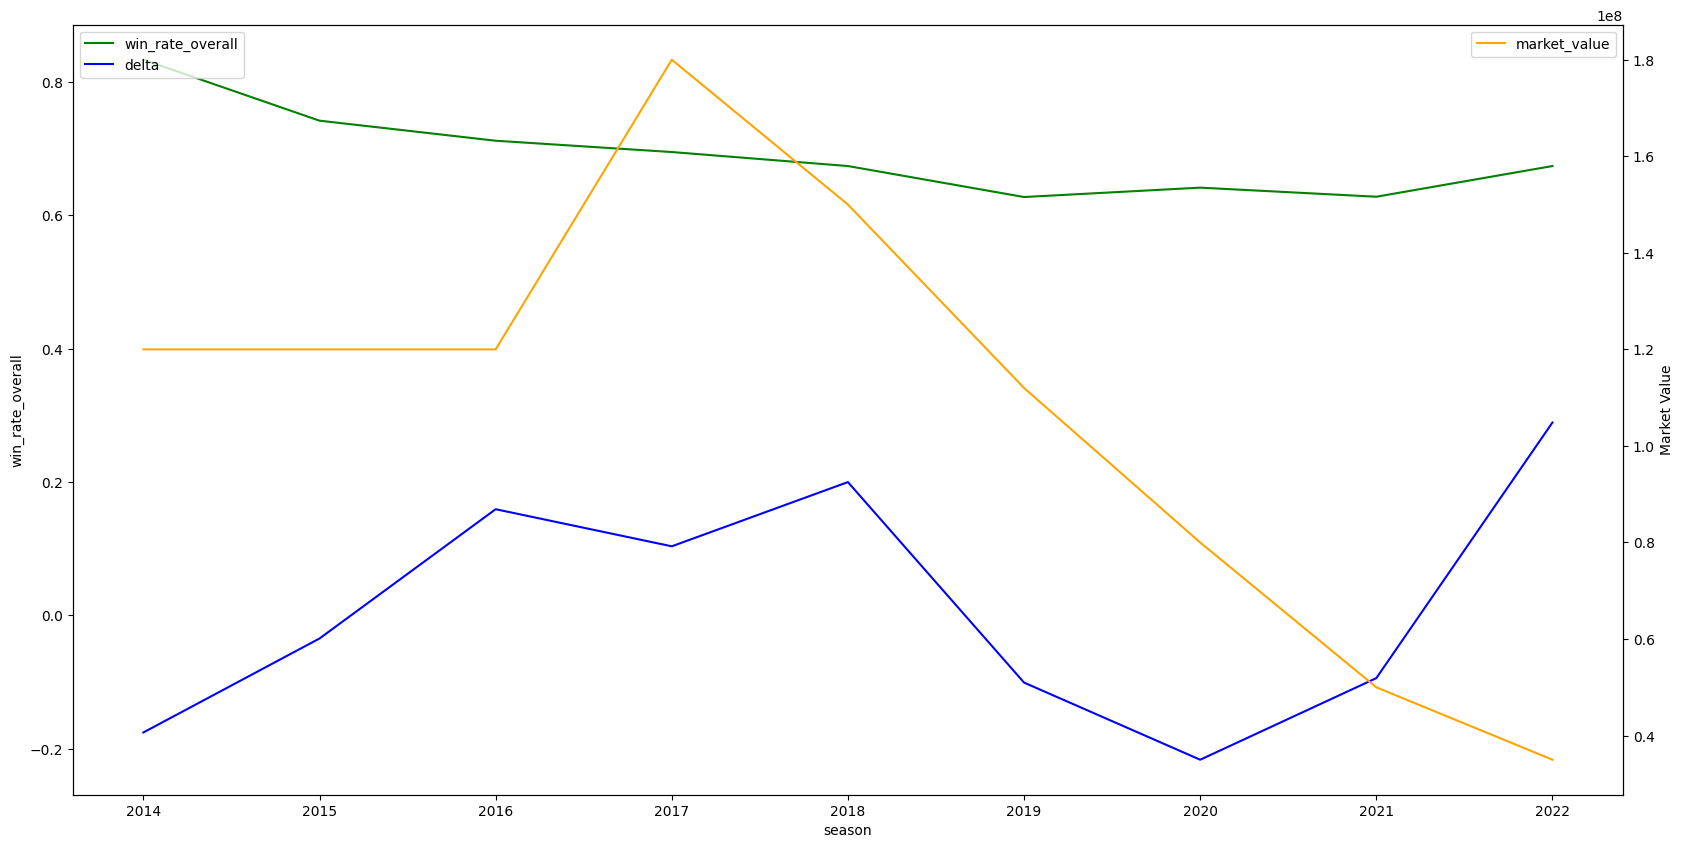

In [111]:
single_player_analysis(df_single_player)

We can see that Lionel Messi has always played for teams with an overall high win rate. So we actually would not expect very high values for the win rate delta. The graph shows that in the seasons 2016 - 2018 and also 2022, his team was actually more successful with him on the pitch. But in all the other seasons, his team was more successfull with him off pitch. This underlines the hypothesis that this metric alone cannot be used to infer a players impact on a team.

And at last we look at Kylian Mbappe, who is the rising star of football.

In [90]:
df_single_player = merged_results[merged_results["player_id"]==342229]

In [94]:
df_single_player.head(10)

,player_id,season,club_id,draws_in_matches_played,losses_in_matches_played,wins_in_matches_played,wins_in_matches_not_played,draws_in_matches_not_played,losses_in_matches_not_played,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,win_rate_overall,name,position,club name,market_value_in_eur
798,342229,2015,162,5,3,4,7,3,2,12,12,0.333333,0.583333,-0.250000,0.458333,Kylian Mbappé,Attack,AS Monaco,1500000
799,342229,2016,162,7,4,27,12,0,4,38,16,0.710526,0.750000,-0.039474,0.722222,Kylian Mbappé,Attack,AS Monaco,35000000
800,342229,2017,162,0,1,1,0,0,0,2,0,0.500000,NaN,NaN,0.500000,Kylian Mbappé,Attack,AS Monaco,150000000
801,342229,2017,583,5,6,24,6,1,0,35,7,0.685714,0.857143,-0.171429,0.714286,Kylian Mbappé,Attack,Paris Saint-Germain,150000000
16531,342229,2018,583,5,5,27,7,1,2,37,10,0.729730,0.700000,0.029730,0.723404,Kylian Mbappé,Attack,Paris Saint-Germain,200000000
16532,342229,2019,583,2,4,25,6,1,1,31,8,0.806452,0.750000,0.056452,0.794872,Kylian Mbappé,Attack,Paris Saint-Germain,180000000
16533,342229,2020,583,4,9,29,4,1,4,42,9,0.690476,0.444444,0.246032,0.647059,Kylian Mbappé,Attack,Paris Saint-Germain,160000000
16534,342229,2021,583,9,5,29,1,1,2,43,4,0.674419,0.250000,0.424419,0.638298,Kylian Mbappé,Attack,Paris Saint-Germain,160000000


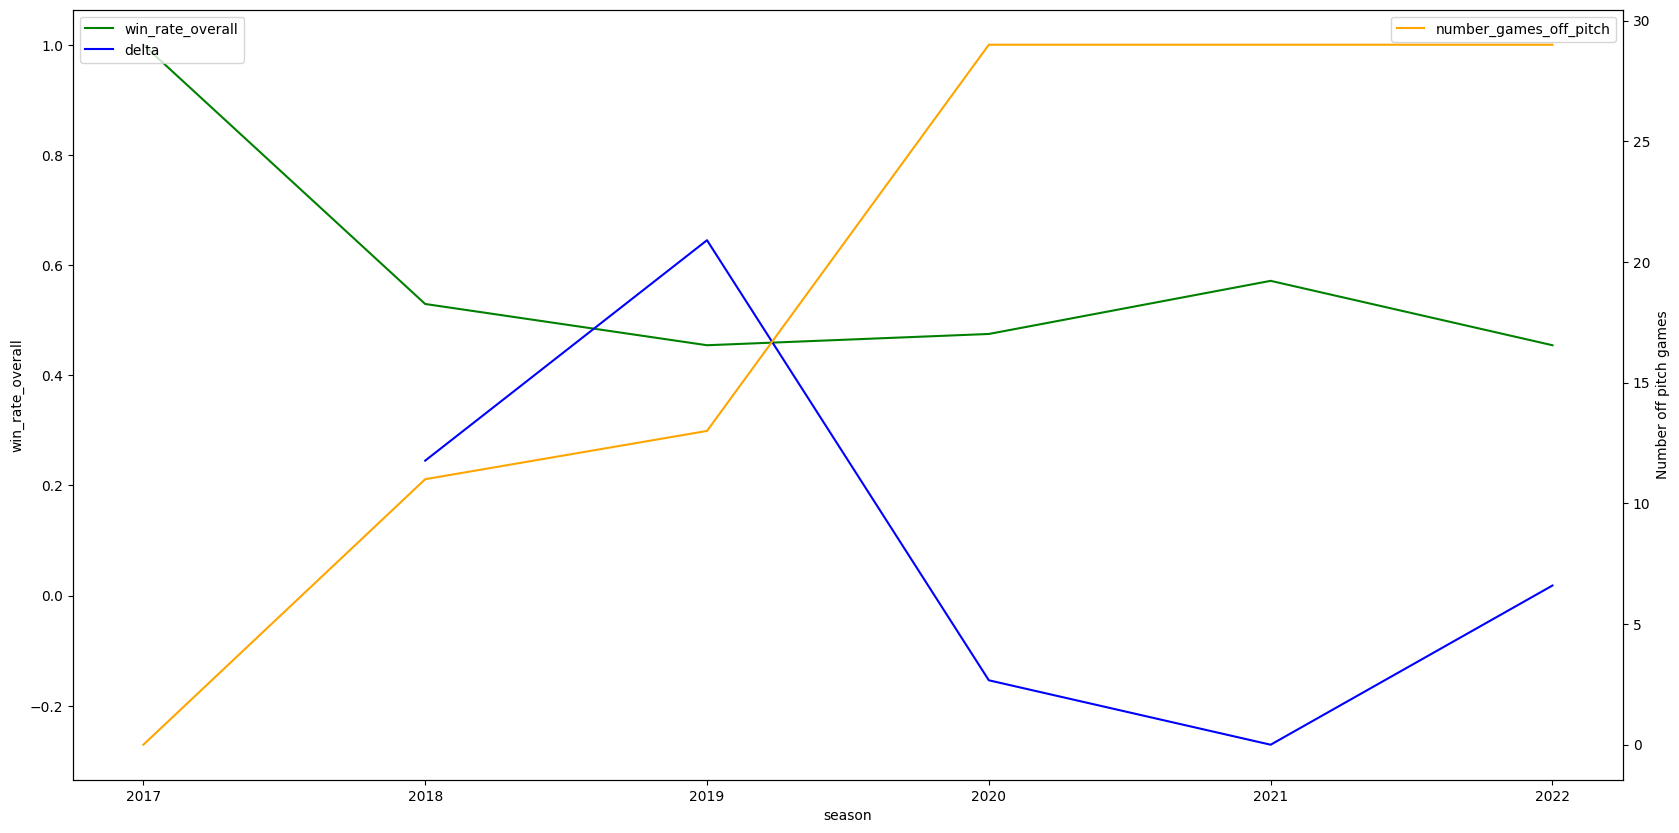

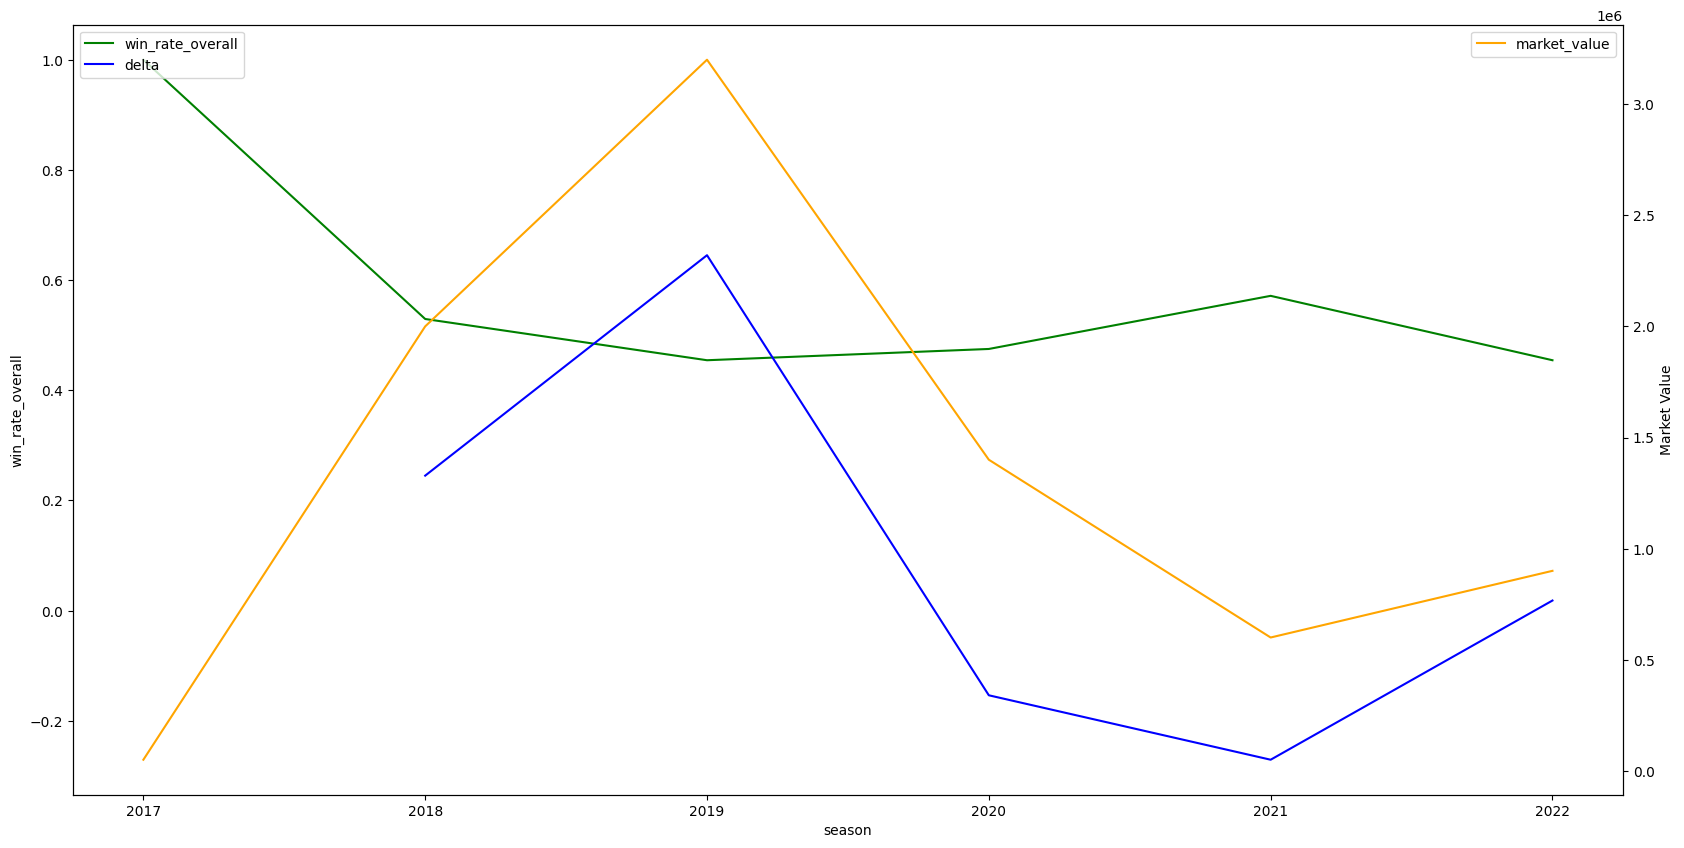

In [107]:
single_player_analysis(df_single_player)

For him we can actually see a rising trend for the delta win rate with the highest value of 0.42. This could imply that he is rather important for his team. 

# Evaluation of Results and Conclusion

Upon reflection, it becomes evident that drawing definitive conclusions from this particular metric is challenging. This difficulty primarily stems from certain limitations inherent in the underlying data. Specifically, our analysis encompassed all games a player did not participate in, without discriminating between the reasons for their absence. Whether a player was sidelined due to injury, left out by the coach’s decision, or for any other reason, all instances were treated equivalently. 

It is therefore necessary in a follow up analysis to actually only look at the games a player misses a match involuntarily (e.g. due to injury) and the recalculate this metric of the delta win rate. I am sure this will lead to different and interesting results